# Benjamin Perez Covo - 202323601
# Camilo Ochoa - 202321705

El objetivo es construir un modelo de regresión capaz de predecir el CVD Risk Score en pacientes adultos utilizando variables clínicas y demográficas.

## Cargar datos y librerias

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

In [337]:
datos_pacientes = pd.read_csv('./data/Datos Lab 1.csv', sep=',')
data = datos_pacientes.copy()
data.head()
display(data.sample(5))
data.shape
data.info()


,Patient ID,Date of Service,Sex,Age,Weight (kg),Height (m),BMI,Abdominal Circumference (cm),Blood Pressure (mmHg),Total Cholesterol (mg/dL),...,Physical Activity Level,Family History of CVD,Height (cm),Waist-to-Height Ratio,Systolic BP,Diastolic BP,Blood Pressure Category,Estimated LDL (mg/dL),CVD Risk Score,CVD Risk Level
1053,qfwo1163,2024-10-04,F,57.0,89.651,1.603,27.783,70.403,129/108,NaN,...,Moderate,Y,160.326,0.439,129.0,108.0,Hypertension Stage 2,112.0,-15.968,INTERMEDIARY
440,ZKZJ8542,"August 22, 2024",F,43.0,114.200,NaN,40.900,91.100,146/60,263.0,...,Low,N,167.000,0.546,146.0,60.0,Hypertension Stage 2,163.0,22.740,HIGH
1349,miQs7675,03 May 22,M,37.0,112.700,1.640,41.900,76.100,98/92,189.0,...,High,Y,164.000,0.464,98.0,92.0,Hypertension Stage 2,91.0,2.359,HIGH
291,UQyn8657,30 Aug 24,F,37.0,15.036,1.870,25.900,87.600,113/75,252.0,...,High,Y,187.000,0.468,113.0,75.0,Normal,143.0,17.870,HIGH
124,RYQk6768,25 Jul 23,F,41.0,54.800,1.780,17.300,105.400,92/73,NaN,...,Low,Y,NaN,0.592,92.0,73.0,Normal,26.0,12.160,INTERMEDIARY


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1639 entries, 0 to 1638
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Patient ID                    1639 non-null   object 
 1   Date of Service               1639 non-null   object 
 2   Sex                           1639 non-null   object 
 3   Age                           1571 non-null   float64
 4   Weight (kg)                   1566 non-null   float64
 5   Height (m)                    1578 non-null   float64
 6   BMI                           1586 non-null   float64
 7   Abdominal Circumference (cm)  1578 non-null   float64
 8   Blood Pressure (mmHg)         1639 non-null   object 
 9   Total Cholesterol (mg/dL)     1571 non-null   float64
 10  HDL (mg/dL)                   1557 non-null   float64
 11  Fasting Blood Sugar (mg/dL)   1585 non-null   float64
 12  Smoking Status                1639 non-null   object 
 13  Dia

## Descripción de los datos

In [233]:
data.describe()

,Age,Weight (kg),Height (m),BMI,Abdominal Circumference (cm),Total Cholesterol (mg/dL),HDL (mg/dL),Fasting Blood Sugar (mg/dL),Height (cm),Waist-to-Height Ratio,Systolic BP,Diastolic BP,Estimated LDL (mg/dL),CVD Risk Score
count,1571.000000,1566.000000,1578.000000,1586.000000,1578.000000,1571.000000,1557.000000,1585.000000,1571.000000,1563.000000,1578.000000,1554.000000,1582.000000,1610.000000
mean,46.803186,85.666006,1.757439,28.424744,91.538861,199.043673,56.183558,117.836860,175.770082,0.522440,125.632637,82.887536,113.235896,18.227281
std,13.039479,21.712504,0.118012,7.309275,13.427985,59.388670,16.721702,32.379634,11.695880,0.085692,22.577463,15.503625,61.435291,10.767666
min,6.134000,13.261000,1.371000,4.317000,49.542000,-1.256000,0.008000,15.306000,136.498000,0.250000,49.914000,31.720000,-92.055000,-20.057000
25%,37.000000,67.100000,1.666500,22.600000,79.700000,150.000000,42.000000,92.000000,167.000000,0.453000,108.000000,71.000000,62.000000,15.150000
50%,46.000000,86.314000,1.760000,28.000000,91.200000,199.000000,56.000000,115.000000,176.000000,0.519000,125.000000,82.000000,112.000000,16.967000
75%,55.000000,104.801500,1.850000,33.963000,102.267250,250.000000,70.000000,139.000000,185.000000,0.582000,141.000000,93.000000,159.000000,18.900000
max,89.420000,158.523000,2.146000,53.028000,136.336000,385.679000,110.315000,219.667000,214.394000,0.804000,202.711000,134.066000,317.314000,114.980000


In [234]:
print(data['Sex'].value_counts(), '\n')
print(data['Physical Activity Level'].value_counts(), '\n')
print(data['Blood Pressure Category'].value_counts(), '\n')

Sex
M    821
F    818
Name: count, dtype: int64 

Physical Activity Level
High        582
Moderate    537
Low         520
Name: count, dtype: int64 

Blood Pressure Category
Hypertension Stage 2    680
Hypertension Stage 1    527
Normal                  321
Elevated                111
Name: count, dtype: int64 



In [235]:
print(data['Smoking Status'].value_counts(), '\n')
print(data['Diabetes Status'].value_counts(), '\n')
print(data['Family History of CVD'].value_counts(), '\n')

Smoking Status
Y    850
N    789
Name: count, dtype: int64 

Diabetes Status
N    821
Y    818
Name: count, dtype: int64 

Family History of CVD
N    820
Y    819
Name: count, dtype: int64 



## Calidad de datos
### Completitud

In [236]:
((data.isnull().sum()/data.shape[0])).sort_values(ascending=False)

Diastolic BP                    0.051861
HDL (mg/dL)                     0.050031
Waist-to-Height Ratio           0.046370
Weight (kg)                     0.044539
Total Cholesterol (mg/dL)       0.041489
Age                             0.041489
Height (cm)                     0.041489
Height (m)                      0.037218
Abdominal Circumference (cm)    0.037218
Systolic BP                     0.037218
Estimated LDL (mg/dL)           0.034777
Fasting Blood Sugar (mg/dL)     0.032947
BMI                             0.032337
CVD Risk Score                  0.017694
Sex                             0.000000
Patient ID                      0.000000
Date of Service                 0.000000
Family History of CVD           0.000000
Diabetes Status                 0.000000
Smoking Status                  0.000000
Blood Pressure (mmHg)           0.000000
Physical Activity Level         0.000000
Blood Pressure Category         0.000000
CVD Risk Level                  0.000000
dtype: float64

Las variables que cuentan con una completitud relativamente alta pues faltan entre 1% y 4% por lo que en estos casos donde estan vacias se inputaran con la mediana ya que a differencia de la media no tiene en cuenta los outliers. Tampoco se eliminan ya que esto implicaria perder mucha información.

### Unicidad

In [237]:
data.duplicated().sum()


np.int64(151)

Hay 302 registros duplicados (151 duplicas) para los cuales se decidio borrar todos los duplicados ya que pueden generar sesgo en el modelo al sobre-representar ciertos perfiles clínicos, afectando la generalización.

### Consistencia

Como pudimos observar previamente en la descripcion de las variables categoricas, todas son consistentes con sus categorias permitadas.

Ademas se puede observar que hay variables como Indice de masa, peso y altura, lo cual incrementa la multicolinealidad ya que se explican entre ellas y por lo tanto es pertinete revisar su relación posteriormente.

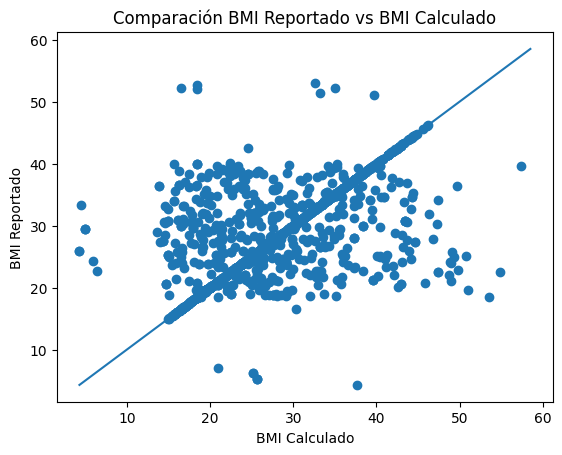

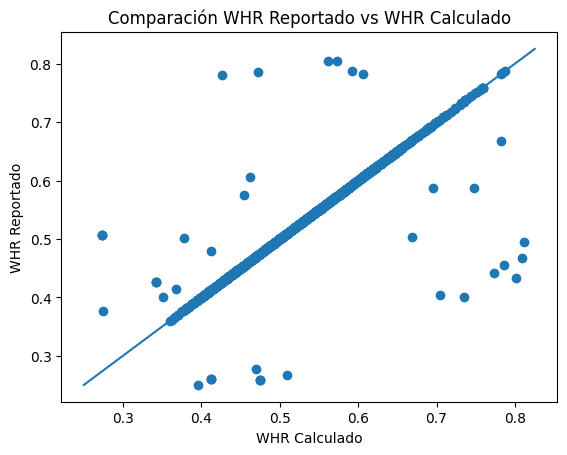

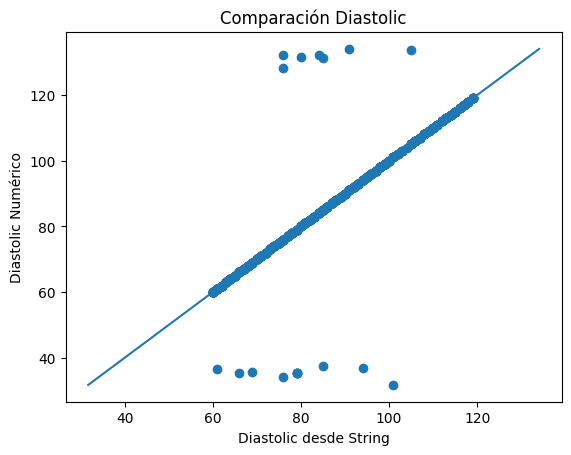

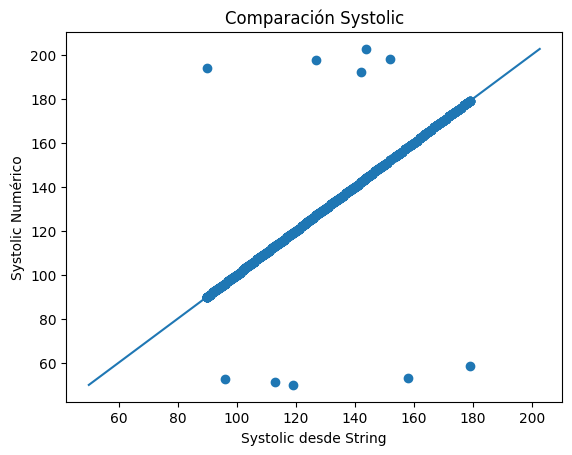

In [ ]:
# Indice de masa
data['BMI_calculado'] = data['Weight (kg)'] / (data['Height (m)']**2)
plt.figure()
plt.scatter(data['BMI_calculado'], data['BMI'])
plt.xlabel("BMI Calculado")
plt.ylabel("BMI Reportado")
plt.title("Comparación BMI Reportado vs BMI Calculado")
min_val = min(data['BMI_calculado'].min(), data['BMI'].min())
max_val = max(data['BMI_calculado'].max(), data['BMI'].max())
plt.plot([min_val, max_val], [min_val, max_val])

plt.show()

# Weight to height ratio

data['WHR_calculado'] = data['Abdominal Circumference (cm)'] / data['Height (cm)']
plt.figure()
plt.scatter(data['WHR_calculado'], data['Waist-to-Height Ratio'])
plt.xlabel("WHR Calculado")
plt.ylabel("WHR Reportado")
plt.title("Comparación WHR Reportado vs WHR Calculado")

min_val = min(data['WHR_calculado'].min(), data['Waist-to-Height Ratio'].min())
max_val = max(data['WHR_calculado'].max(), data['Waist-to-Height Ratio'].max())
plt.plot([min_val, max_val], [min_val, max_val])

plt.show()

# Blood preassure

bp_split = data['Blood Pressure (mmHg)'].str.split('/', expand=True) # Blood preassure se calcula como Systolic/Diastolic entoonces se quiere verificar que sea consistente

data['Systolic_from_string'] = pd.to_numeric(bp_split[0], errors='coerce')
data['Diastolic_from_string'] = pd.to_numeric(bp_split[1], errors='coerce')

plt.figure()
plt.scatter(data['Diastolic_from_string'], data['Diastolic BP'])
plt.xlabel("Diastolic desde String")
plt.ylabel("Diastolic Numérico")
plt.title("Comparación Diastolic")

min_val = min(data['Diastolic BP'].min(), data['Diastolic_from_string'].min())
max_val = max(data['Diastolic BP'].max(), data['Diastolic_from_string'].max())
plt.plot([min_val, max_val], [min_val, max_val])

plt.show()

plt.figure()
plt.scatter(data['Systolic_from_string'], data['Systolic BP'])
plt.xlabel("Systolic desde String")
plt.ylabel("Systolic Numérico")
plt.title("Comparación Systolic")

min_val = min(data['Systolic BP'].min(), data['Systolic_from_string'].min())
max_val = max(data['Systolic BP'].max(), data['Systolic_from_string'].max())
plt.plot([min_val, max_val], [min_val, max_val])

plt.show()

# Eliminarlas del dataset

data.drop(columns=[
    'BMI_calculado',
    'WHR_calculado',
    'Systolic_from_string',
    'Diastolic_from_string'
], inplace=True, errors='ignore')


# Se utilizo la Inteligencia Aritificial de ChatGPT para generar el codigo que genere los graficos 
# de comparacion entre las variables calculadas y las reportadas



La presión de sangre y el weight to height ratio se mantiene consistente la relación por lo que los valores otorgados si comparten una relacion real con sus variables explicativas. Teniendo esto en cuenta, posteriormente en la manipulación de datos se pueden reducir estas variables para reducir la multicolinealidad de la regresión y mejorar su resultado. 

En el BMI por el contrario la grafica si muestra una dispersion fuerte e inconsisitente por lo que se eliminara y se recalculara a partir del peso y la altura de cada persona.

### Validez 

In [239]:
data.describe()


,Age,Weight (kg),Height (m),BMI,Abdominal Circumference (cm),Total Cholesterol (mg/dL),HDL (mg/dL),Fasting Blood Sugar (mg/dL),Height (cm),Waist-to-Height Ratio,Systolic BP,Diastolic BP,Estimated LDL (mg/dL),CVD Risk Score
count,1571.000000,1566.000000,1578.000000,1586.000000,1578.000000,1571.000000,1557.000000,1585.000000,1571.000000,1563.000000,1578.000000,1554.000000,1582.000000,1610.000000
mean,46.803186,85.666006,1.757439,28.424744,91.538861,199.043673,56.183558,117.836860,175.770082,0.522440,125.632637,82.887536,113.235896,18.227281
std,13.039479,21.712504,0.118012,7.309275,13.427985,59.388670,16.721702,32.379634,11.695880,0.085692,22.577463,15.503625,61.435291,10.767666
min,6.134000,13.261000,1.371000,4.317000,49.542000,-1.256000,0.008000,15.306000,136.498000,0.250000,49.914000,31.720000,-92.055000,-20.057000
25%,37.000000,67.100000,1.666500,22.600000,79.700000,150.000000,42.000000,92.000000,167.000000,0.453000,108.000000,71.000000,62.000000,15.150000
50%,46.000000,86.314000,1.760000,28.000000,91.200000,199.000000,56.000000,115.000000,176.000000,0.519000,125.000000,82.000000,112.000000,16.967000
75%,55.000000,104.801500,1.850000,33.963000,102.267250,250.000000,70.000000,139.000000,185.000000,0.582000,141.000000,93.000000,159.000000,18.900000
max,89.420000,158.523000,2.146000,53.028000,136.336000,385.679000,110.315000,219.667000,214.394000,0.804000,202.711000,134.066000,317.314000,114.980000


A partir del analisis preliminar de los datos de la funcion .describe() se puedieron encontrar las siguientes anomalias o datos atipicos:

- Se encontro registros con edades de minimo 6.13 años y dado el contexto el caso se enfoca en adultos jovenes y mayores por lo que se eliminaran todos los registros que tengan <18 años

- El colesterol total presenta valores negativas al igual que el Estimated LDL lo cual es fisiologicamente imposible por lo que se aceptaran datos unicamente con valores mayores a cero.

- Valores demasiado bajos en HDL y Fasting Blood Sugar. Se aceptaran los datos cuya HDL este entre 10 y 120 y su Fasting Blood Sugar entre 50-400

- Presiones arteriales inferiores a rangos compatibles con estabilidad. Se aceptaran rangos de Systolic BP entre 80 y 250 y para Diastolic entre 40 y 150

- Valores negativos en la variable objetivo de CVD Risk Score. Se tomaran en cuenta unicamente registros con CVD Risk Score mayor a cero.


Se utilizo ChatGPT para analizar el resultado de data.describe() y encontrar valores que para la respectiva categoria no deberian ser posibles o son atipicos y tambien conocer cuales son rangos que a pesar de ser extremos son aceptables. Estos ya que no conocemos mucho sobre los rangos esperados de ciertas mediciones.

### Correlación preliminar

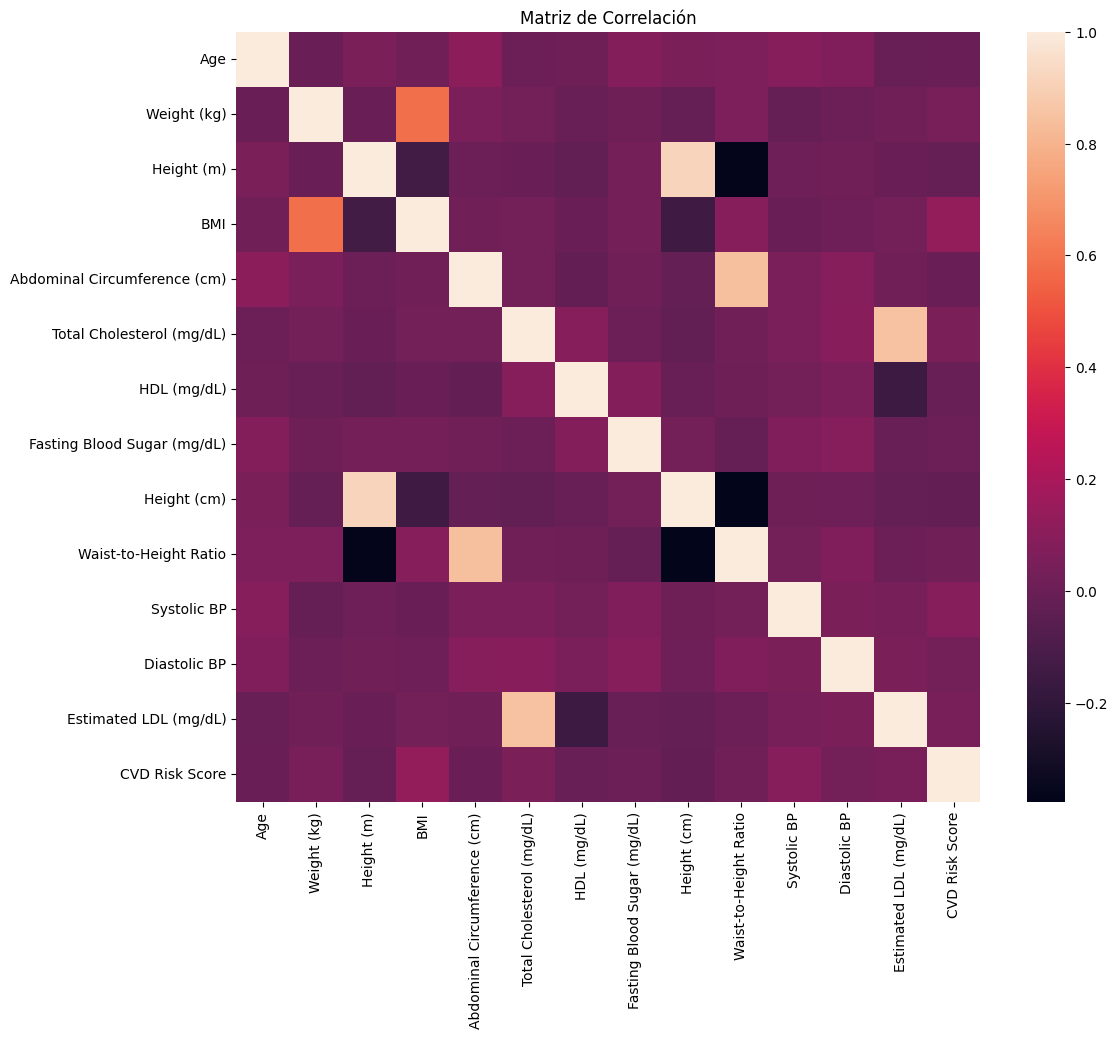

In [240]:
numeric_data = data.select_dtypes(include=['int64', 'float64'])

corr = numeric_data.corr()

plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=False)
plt.title("Matriz de Correlación")
plt.show()


Variables con alta correlación 

- Height(cm) y Height(m)
- Total Cholesterol y Estimated LDL
- Indice de masa y peso
- Waist to Height ratio y Height
- Indice de masa y altura


In [241]:
correlations = data.corr(numeric_only=True)["CVD Risk Score"].sort_values(ascending=False)
print(correlations)

CVD Risk Score                  1.000000
BMI                             0.133475
Systolic BP                     0.086767
Total Cholesterol (mg/dL)       0.053244
Estimated LDL (mg/dL)           0.043440
Weight (kg)                     0.042471
Diastolic BP                    0.026218
Waist-to-Height Ratio           0.020090
Fasting Blood Sugar (mg/dL)     0.000947
Abdominal Circumference (cm)   -0.000946
Age                            -0.004056
HDL (mg/dL)                    -0.011412
Height (m)                     -0.015594
Height (cm)                    -0.023800
Name: CVD Risk Score, dtype: float64


### Manipulación de datos

A partir de la exploracion de datos realizada se pudo observar que habian varias fallas en la calidad de datos pues estos en algunos casos contaban de datos atipicos, correlaciones entre las variables altas, registros repetidos y datos vacios.

En esta sección se va a hacer una manipulación de dautos de manera precavida de modo que se estandaricen y se corrigan las anomalias presentadas en los datos del manera que se utilice un data set con una alta calidad para poder construir el modelo adecuadamente. A continuación explicamos que lógica y metodos se utilizaron para esto:

Completitud: Se inputan los datos con la mediana, esta no esta sesgada por datos atipicos

Unicidad: Se eliminan por completo los registros duplicados

Consistencia: Se re calcula el Indice de masa corporal a partir de los datos de la persona ya que el ibm reportado no coincide con el calculado.

Validez: Se utilizaran unicamente los registros que esten dentro de los rangos permitidos para las diferentes variables y evitar asi datos atipicos y anomialias que puedan afectar el modelo.

Multicolinealidad: Se eliminaran las variables que encontramos se explicaban entre ellas durante la verificación de consistencia, y además se analizaran las variables con alta correlación de manera mas exhaustiva utilizando el indicador de VIF para revisar multicolinealidad.

In [338]:
data = data.drop_duplicates()

# Se eliminan Height (cm) y Waist-to-Height Ratio porque no aportan información adicional, Blood Pressure (mmHg) porque se puede calcular a partir de Systolic BP y Diastolic BP, y BMI porque se puede calcular a partir de Weight (kg) y Height (m).

data.drop(columns=[
    'Height (cm)',
    'Waist-to-Height Ratio',
    'Blood Pressure (mmHg)',
    'BMI'
], inplace=True)

data = data.drop("Patient ID", axis=1)
data = data.drop("Date of Service", axis=1)



data = data[data['Age'] >= 18]

data = data[data['Estimated LDL (mg/dL)'] > 0]
data = data[data['CVD Risk Score'] >= 0]

data = data[(data['HDL (mg/dL)'] >= 10) & 
            (data['HDL (mg/dL)'] <= 120)]

data = data[(data['Fasting Blood Sugar (mg/dL)'] >= 50) & 
            (data['Fasting Blood Sugar (mg/dL)'] <= 400)]

data = data[(data['Systolic BP'] >= 80) & 
            (data['Systolic BP'] <= 250)]

data = data[(data['Diastolic BP'] >= 40) & 
            (data['Diastolic BP'] <= 150)]

num_cols = data.select_dtypes(include=['int64','float64']).columns

imputer = SimpleImputer(strategy='median')
data[num_cols] = imputer.fit_transform(data[num_cols])




                        Variable         VIF
0                          const  373.965851
1                            Age    1.028701
2                    Weight (kg)    1.003242
3                     Height (m)    1.005894
4   Abdominal Circumference (cm)    1.021169
5      Total Cholesterol (mg/dL)    4.165984
6                    HDL (mg/dL)    1.279611
7    Fasting Blood Sugar (mg/dL)    1.034453
8                    Systolic BP    1.018765
9                   Diastolic BP    1.034193
10         Estimated LDL (mg/dL)    4.223316


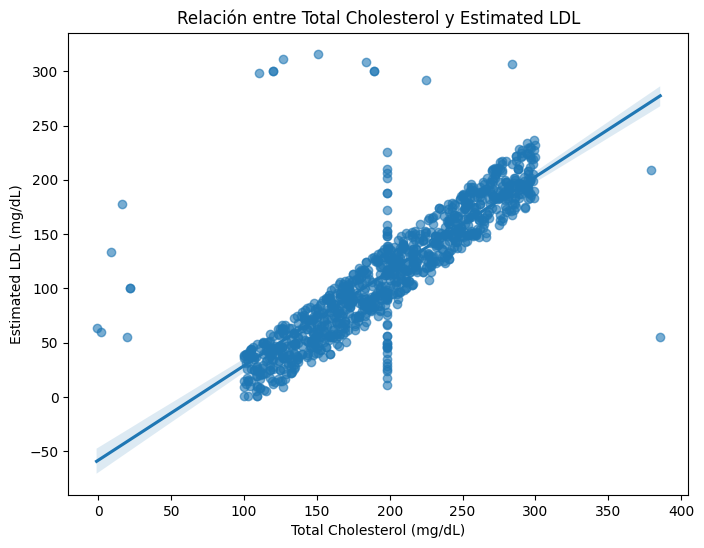

In [339]:
X = data.drop('CVD Risk Score', axis=1)

X = X.select_dtypes(include=['int64', 'float64'])

X = add_constant(X)

vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif)


plt.figure(figsize=(8,6))

sns.regplot(
    x='Total Cholesterol (mg/dL)', 
    y='Estimated LDL (mg/dL)', 
    data=data,
    scatter_kws={'alpha':0.6}
)

plt.title('Relación entre Total Cholesterol y Estimated LDL')
plt.xlabel('Total Cholesterol (mg/dL)')
plt.ylabel('Estimated LDL (mg/dL)')
plt.show()

## Se utilizo la Inteligencia Aritificial de ChatGPT para generar el codigo que calcula el VIF de las variables explicativas
## y ademas el codigo que genera la grafica de relacion entre Total Cholesterol y Estimated LDL para evaluar su relación.



Encontramos que Estimated LDL  y total Cholesterol tienen un VIF de 4.999 (si bien no es nada grave es relativamente alto), ádemas de eso en la grafica podemos observar que tienen una relación casi que directa por lo que se va a eliminar una de las dos. 

Como es una relación moderada se dejaron las dos variables y posteriormente en el segundo modelo se va a analizar mas a detalle si eliminar una o no.

In [287]:
"""data.drop(columns=['Total Cholesterol (mg/dL)'], inplace=True)
"""

#Confirmamos no quedan datos vacíos
print("datos vacios:", data.isna().sum().sum())



datos vacios: 0


In [245]:
data.head() # Revisamos con que quedamos


,Sex,Age,Weight (kg),Height (m),Abdominal Circumference (cm),Total Cholesterol (mg/dL),HDL (mg/dL),Fasting Blood Sugar (mg/dL),Smoking Status,Diabetes Status,Physical Activity Level,Family History of CVD,Systolic BP,Diastolic BP,Blood Pressure Category,Estimated LDL (mg/dL),CVD Risk Score,CVD Risk Level
0,M,44.0,114.300,1.720,100.000,228.0,77.0,91.0,Y,Y,High,N,112.0,83.0,Hypertension Stage 1,121.0,19.880,HIGH
1,F,57.0,92.923,1.842,106.315,158.0,71.0,76.0,N,Y,High,Y,101.0,91.0,Hypertension Stage 2,57.0,16.833,INTERMEDIARY
3,F,35.0,113.300,1.780,79.600,158.0,34.0,111.0,Y,N,Moderate,Y,92.0,89.0,Hypertension Stage 1,94.0,14.920,HIGH
4,F,48.0,102.200,1.750,106.700,207.0,49.0,147.0,Y,Y,Low,Y,121.0,68.0,Elevated,128.0,18.870,HIGH
5,M,43.0,52.700,1.850,107.700,105.0,32.0,70.0,Y,N,High,N,107.0,61.0,Normal,43.0,10.530,INTERMEDIARY


### Analizar variable objetivo

In [246]:
data["CVD Risk Score"].describe()

count    1083.000000
mean       18.640632
std        11.341848
min         0.883000
25%        15.210000
50%        17.050000
75%        19.040000
max       114.980000
Name: CVD Risk Score, dtype: float64

Cuenta con outliers muy fuertes por lo que elimine outliers 

In [340]:
Q1 = data["CVD Risk Score"].quantile(0.25)
Q3 = data["CVD Risk Score"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

data = data[
    (data["CVD Risk Score"] >= lower_bound) &
    (data["CVD Risk Score"] <= upper_bound)
]


data["CVD Risk Score"].describe()

count    1025.000000
mean       17.027035
std         2.544114
min        10.530000
25%        15.230000
50%        16.920000
75%        18.830000
max        24.449000
Name: CVD Risk Score, dtype: float64

## Modelo predictivo 1

### Definicion de variable objetivo y predictoras

En esta sección se define la variable objetivo (CVD Risk Score) y el conjunto de variables predictoras.
Dado que se trata de una variable continua, el problema corresponde a una tarea de regresión supervisada.

In [341]:

print(data.groupby("CVD Risk Level")["CVD Risk Score"].describe())

# Eliminamos la variable objetivo categórica, no es coherente con el risk score, y no aporta información adicional.
data = data.drop("CVD Risk Level", axis=1)


X = data.drop("CVD Risk Score", axis=1)
y = data["CVD Risk Score"]

print("\nDimensiones de X:", X.shape)
print("Dimensiones de y:", y.shape)


                count       mean       std    min      25%      50%       75%  \
CVD Risk Level                                                                  
HIGH            498.0  17.540299  2.318949  10.89  16.0200  17.5855  19.24925   
INTERMEDIARY    380.0  16.319305  2.527216  10.53  14.5825  16.0695  17.87250   
LOW             147.0  17.117728  2.881069  10.86  14.4715  16.9210  19.37250   

                   max  
CVD Risk Level          
HIGH            24.449  
INTERMEDIARY    23.510  
LOW             23.797  

Dimensiones de X: (1025, 16)
Dimensiones de y: (1025,)


La variable CVD Risk Level fue eliminada porque no presenta coherencia estadística ni relación estructurada con la variable objetivo.

### Identificacion de variables numericas y categoricas

In [342]:
# Identificar tipos de variables
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object", "category"]).columns.tolist()

print("Variables numéricas:", numeric_features)
print("Variables categóricas:", categorical_features)





Variables numéricas: ['Age', 'Weight (kg)', 'Height (m)', 'Abdominal Circumference (cm)', 'Total Cholesterol (mg/dL)', 'HDL (mg/dL)', 'Fasting Blood Sugar (mg/dL)', 'Systolic BP', 'Diastolic BP', 'Estimated LDL (mg/dL)']
Variables categóricas: ['Sex', 'Smoking Status', 'Diabetes Status', 'Physical Activity Level', 'Family History of CVD', 'Blood Pressure Category']


Revision entre relacion de variables explicativas y objetivo

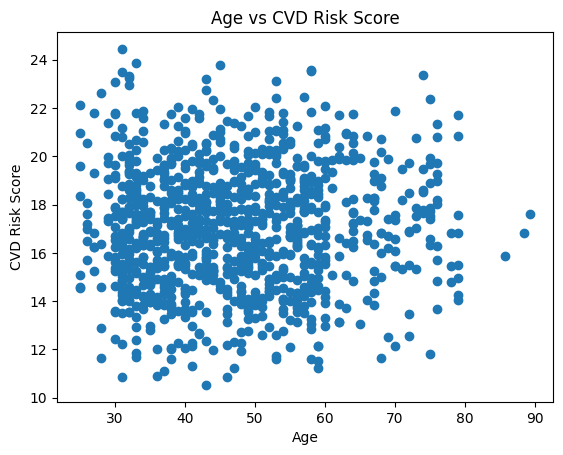

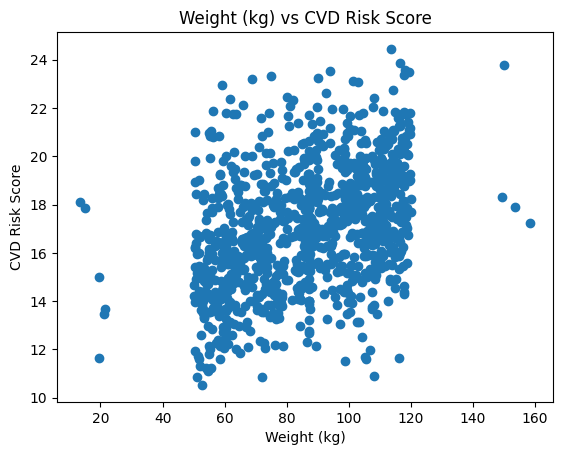

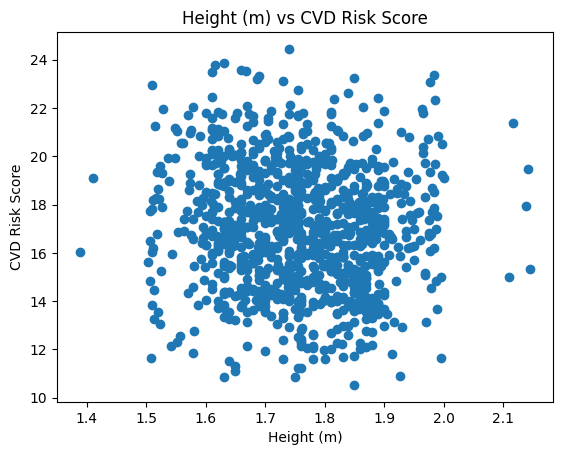

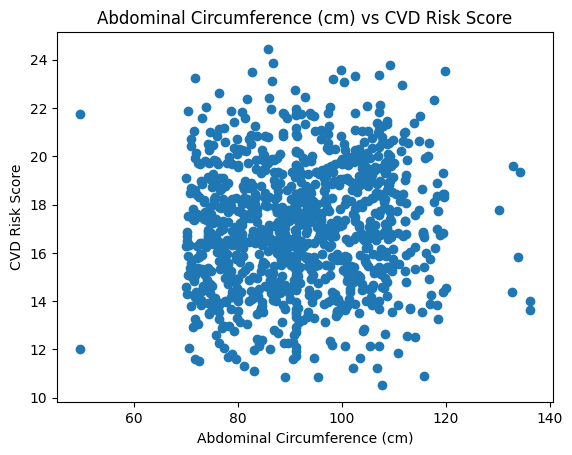

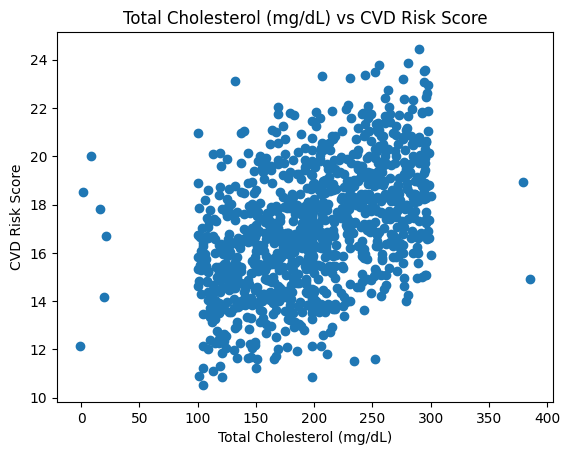

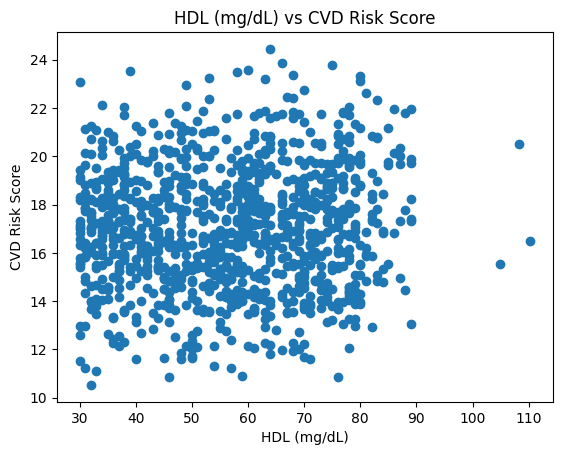

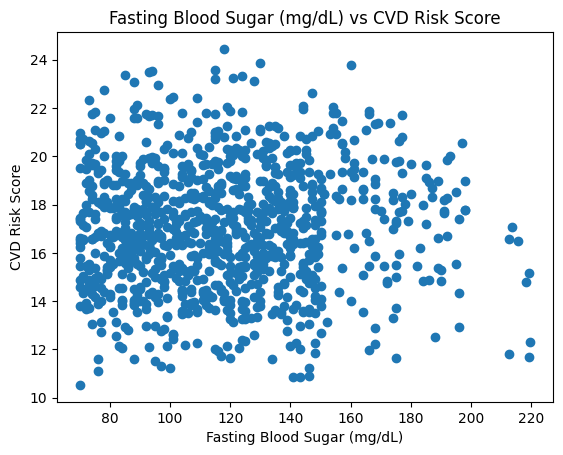

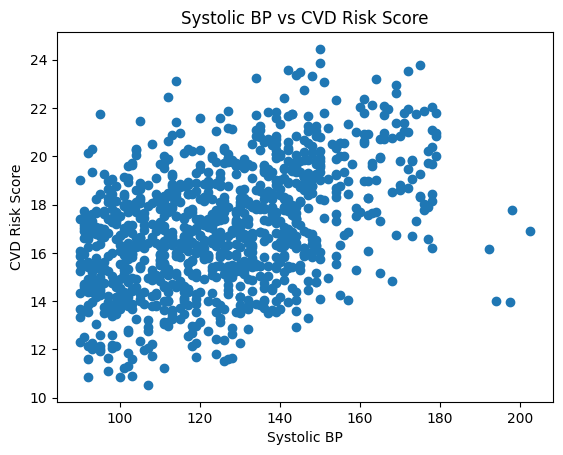

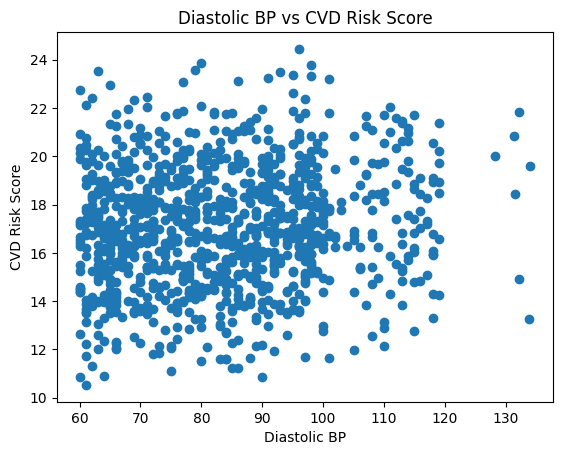

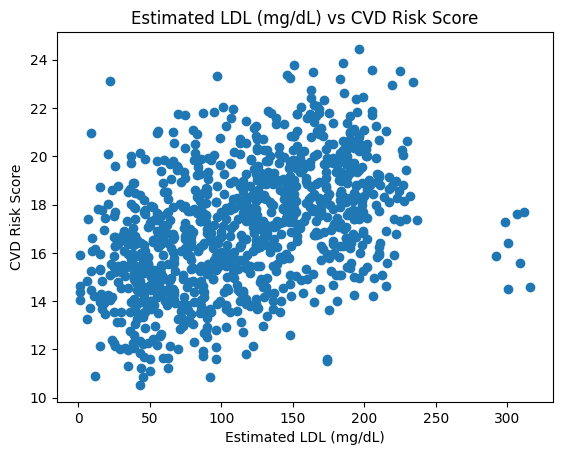

<Figure size 640x480 with 0 Axes>

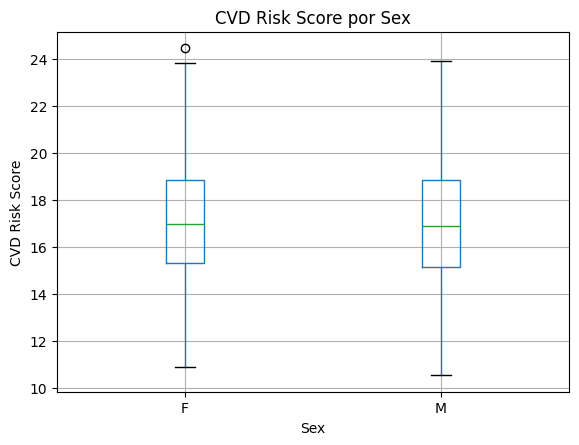

<Figure size 640x480 with 0 Axes>

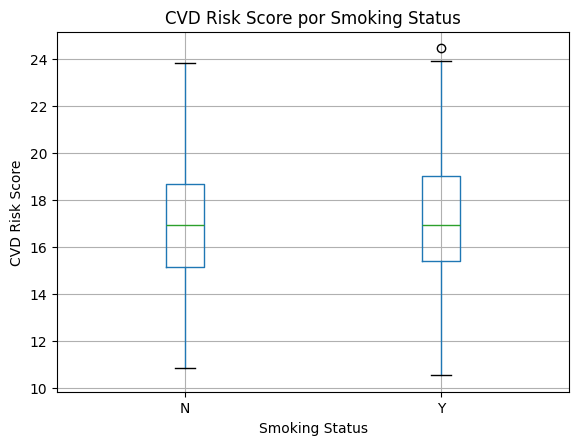

<Figure size 640x480 with 0 Axes>

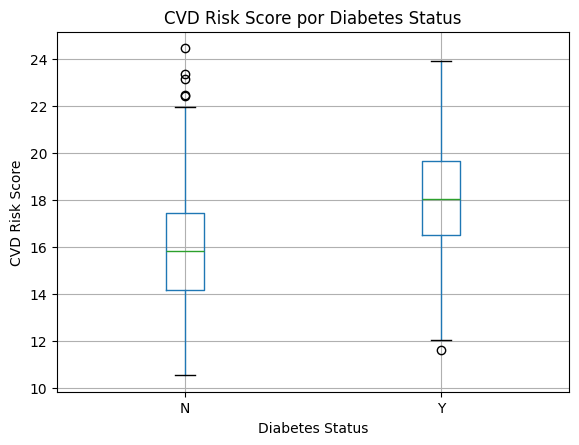

<Figure size 640x480 with 0 Axes>

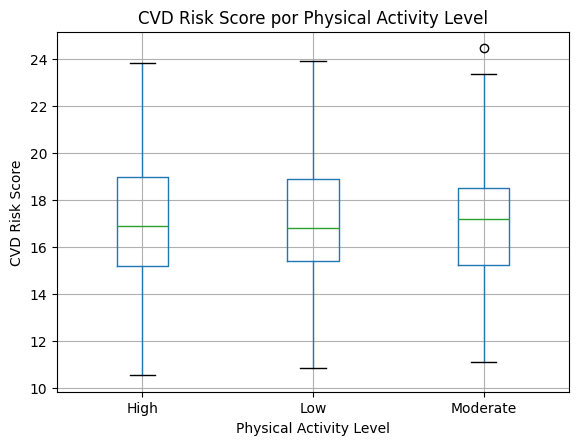

<Figure size 640x480 with 0 Axes>

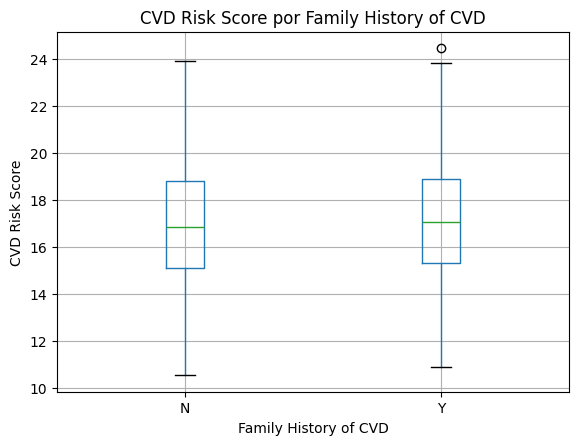

<Figure size 640x480 with 0 Axes>

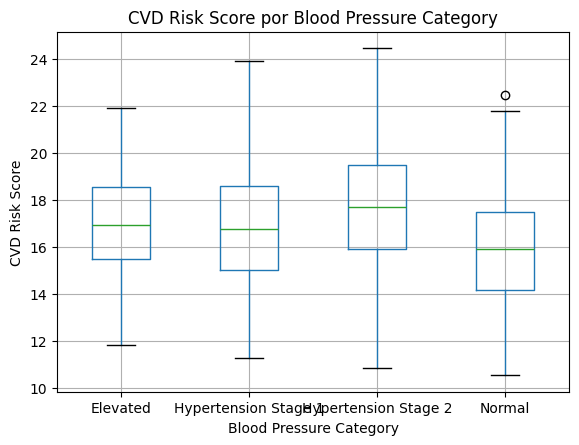

'\nSe utilizo la Inteligencia Aritificial de ChatGPT para generar el codigo que genera los graficos de relacion entre las variables predictoras\n y la variable objetivo, tanto para variables numéricas como categóricas. Esto con el fin de evaluar visualmente la relación entre cada variable \n y el CVD Risk Score, lo que es fundamental para entender el comportamiento de los datos y para la selección de variables.\n '

In [343]:
for col in numeric_features:
    if col != "CVD Risk Score":
        plt.figure()
        plt.scatter(data[col], data["CVD Risk Score"])
        plt.xlabel(col)
        plt.ylabel("CVD Risk Score")
        plt.title(f"{col} vs CVD Risk Score")
        plt.show()

for col in categorical_features:
    plt.figure()
    data.boxplot(column="CVD Risk Score", by=col)
    plt.title(f"CVD Risk Score por {col}")
    plt.suptitle("")
    plt.xlabel(col)
    plt.ylabel("CVD Risk Score")
    plt.show()

"""
Se utilizo la Inteligencia Aritificial de ChatGPT para generar el codigo que genera los graficos de relacion entre las variables predictoras
 y la variable objetivo, tanto para variables numéricas como categóricas. Esto con el fin de evaluar visualmente la relación entre cada variable 
 y el CVD Risk Score, lo que es fundamental para entender el comportamiento de los datos y para la selección de variables.
 """


Las variables que presentan alguna relacion / tendencia son:

- Systolic BP
- Diabetes Status 
- Estimated LDL
- Blood Pressure Category

### Division entrenamiento 

Se realiza una división del conjunto de datos en entrenamiento (75%) y prueba (25%) con el fin de evaluar el desempeño del modelo en datos no vistos durante el entrenamiento.

In [344]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (768, 16)
Test shape: (257, 16)


### Construccion del pipeline

Se construye un pipeline que incluye:

- Escalamiento de variables numéricas

- Codificación One-Hot para variables categóricas

- Modelo de regresión lineal

In [345]:

numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(drop="first", handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression())
])




### Entrenar el modelo

Se entrena el modelo utilizando únicamente el conjunto de entrenamiento.

In [346]:
model.fit(X_train, y_train) 

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('regressor', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformer

## Evaluación del modelo

### Medidas
Se evalua el desempeño del modelo utilizando metricas de regresión como:
- R^2 
- MAE
- RMSE

In [347]:
# Predicciones
y_pred = model.predict(X_test)

# Métricas
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("R²:", r2)
print("MAE:", mae)
print("RMSE:", rmse)


R²: 0.6565277331151764
MAE: 0.9991199074658915
RMSE: 1.504966660683196


### Graficas de Real vs Predicho

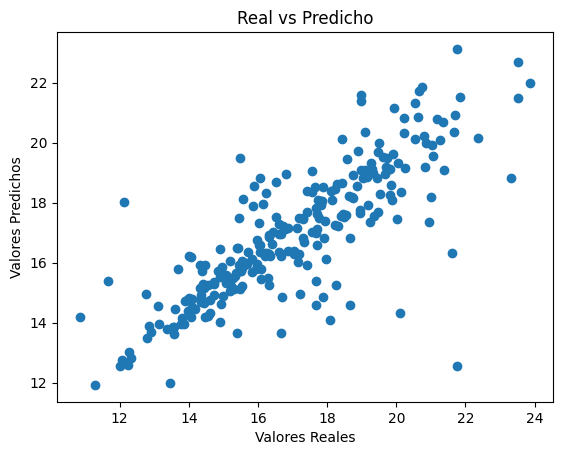

In [348]:

plt.figure()
plt.scatter(y_test, y_pred)
plt.xlabel("Valores Reales")
plt.ylabel("Valores Predichos")
plt.title("Real vs Predicho")
plt.show()


### Grafico de residuos

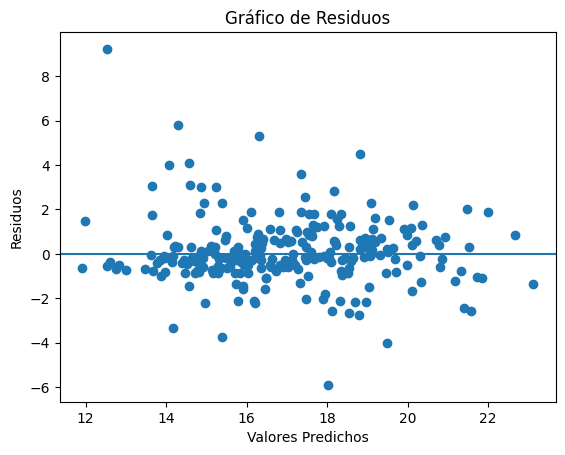

In [349]:
residuals = y_test - y_pred

plt.figure()
plt.scatter(y_pred, residuals)
plt.axhline(y=0)
plt.xlabel("Valores Predichos")
plt.ylabel("Residuos")
plt.title("Gráfico de Residuos")
plt.show()


## Modelo 2

Para este modelo se decidio que se iban a tener en cuenta relaciones que en el primero se decidieron ignorar como el BMI y el WHR y además eliminar eliminar las variables que en el grafico de objetivo vs explicativas se observa que hacen mucho ruido

### Variables a eliminar

- Age: generaba mucho ruido y se encontro que no era estadisticamente significante

- Smoking status: generaba mucho ruido y no aportaba una mejora al modelo

- Family History of CVD: generaba mucho ruido y se encontro que no era estadisticamente significante

- HDL (mg/dL): generaba mucho ruido y se encontro que no era estadisticamente significante

- Phyisical Activity Level: generaba mucho ruido y no aportaba una mejora al modelo

- Sex: generaba mucho ruido y se encontro que no era estadisticamente significante

- Weight y Height: estas variables ya son explicadas por el BMI y individualmente se encontro que no aportaban estadisticamente a el modelo

### Variables que se dejaron:

- WHR: Se tiene en cuenta la altura y el abdominal circumference y se evidencio que su relación aportaba estadisticamente al modelo

- BMI: Tiene en cuenta el peso y la altura y se encontraba que mejoraba la explicación del modelo

- Abdominal circumference: Se encontro que si bien tiene una relación directa con WHR, esta era significativa de manera individual a la hora de construir el modelo

- Total Cholesterol: Si bien en la etapa de exploración de datos se encontre que contaba con un VIF y correlación modearada junto con Estimated LDL, en la creación de este modelo se encontro que cada una de las variables, a pesar de su cierto nivel de correlación, aportaban significativamente a el rendimiento del modelo por lo que se decidio utilizar ambas.

El resto de variables se pudieron observar que generaban un impacto alto en el modelo ya que estaban altamente relacionadas a la variable objetivo



In [355]:

# Crear BMI
data["BMI"] = data["Weight (kg)"] / (data["Height (m)"] ** 2)

# Crear WHR (Waist-to-Height Ratio)
data["WHR"] = data["Abdominal Circumference (cm)"] / (data["Height (m)"] * 100)


data_model2 = data.drop([
    'Age',
    'Smoking Status',
    'Family History of CVD',
    'HDL (mg/dL)',
    'Fasting Blood Sugar (mg/dL)',
    'Physical Activity Level',    
    'Sex',
    'Height (m)',
    'Weight (kg)',
    
    
   
    
], axis=1)



X2 = data_model2.drop("CVD Risk Score", axis=1)
y2 = data_model2["CVD Risk Score"]

print("Shape X2:", X2.shape)

numeric_features2 = X2.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features2 = X2.select_dtypes(include=["object", "category"]).columns.tolist()

print("Numéricas:", numeric_features2)
print("Categóricas:", categorical_features2)    


X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2, y2, test_size=0.25, random_state=42
)

numeric_transformer2 = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer2 = Pipeline(steps=[
    ("onehot", OneHotEncoder(drop="first", handle_unknown="ignore"))
])

preprocessor2 = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer2, numeric_features2),
        ("cat", categorical_transformer2, categorical_features2)
    ]
)

model2 = Pipeline(steps=[
    ("preprocessor", preprocessor2),
    ("regressor", LinearRegression())
])

model2.fit(X2_train, y2_train)


y2_pred = model2.predict(X2_test)

print("R2:", r2_score(y2_test, y2_pred))
print("MAE:", mean_absolute_error(y2_test, y2_pred))
print("RMSE:", np.sqrt(mean_squared_error(y2_test, y2_pred)))



Shape X2: (1025, 9)
Numéricas: ['Abdominal Circumference (cm)', 'Total Cholesterol (mg/dL)', 'Systolic BP', 'Diastolic BP', 'Estimated LDL (mg/dL)', 'BMI', 'WHR']
Categóricas: ['Diabetes Status', 'Blood Pressure Category']
R2: 0.6630237388043672
MAE: 0.986541360919272
RMSE: 1.4906671970346608


## Comparación de modelos

### Tabla comparativa de rendimientos

In [356]:

metrics_model1 = {
    'Modelo': 'Modelo 1',
    'R²': r2_score(y_test, y_pred),
    'MAE': mean_absolute_error(y_test, y_pred),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred))
}

metrics_model2 = {
    'Modelo': 'Modelo 2',
    'R²': r2_score(y2_test, y2_pred),
    'MAE': mean_absolute_error(y2_test, y2_pred),
    'RMSE': np.sqrt(mean_squared_error(y2_test, y2_pred))
}


comparison_df = pd.DataFrame([metrics_model1, metrics_model2])
print(comparison_df.to_string(index=False))

  Modelo       R²      MAE     RMSE
Modelo 1 0.656528 0.999120 1.504967
Modelo 2 0.663024 0.986541 1.490667


Se escogio el Modelo 2 ya que mas alla de presentar una ligera mejora en cuanto a los 'benchmark' del modelo, es decir, que cuenta con mejores estimadores, tambiénn cuenta con una cantidad signficativamente menor de variables explicativas lo que en su efecto hace a el modelo mas sencillo y entendible.

## Importancia de las Variables en el modelo 2

                                    Variable  Coeficiente
                           Diabetes Status_Y     1.930530
                                 Systolic BP     1.084219
                                         BMI     1.071687
                                         WHR    -0.696220
                Abdominal Circumference (cm)     0.678354
                   Total Cholesterol (mg/dL)     0.624490
                       Estimated LDL (mg/dL)     0.500045
Blood Pressure Category_Hypertension Stage 2     0.277699
              Blood Pressure Category_Normal     0.119543
                                Diastolic BP     0.017279
Blood Pressure Category_Hypertension Stage 1     0.011463

Intercepto: 15.9168


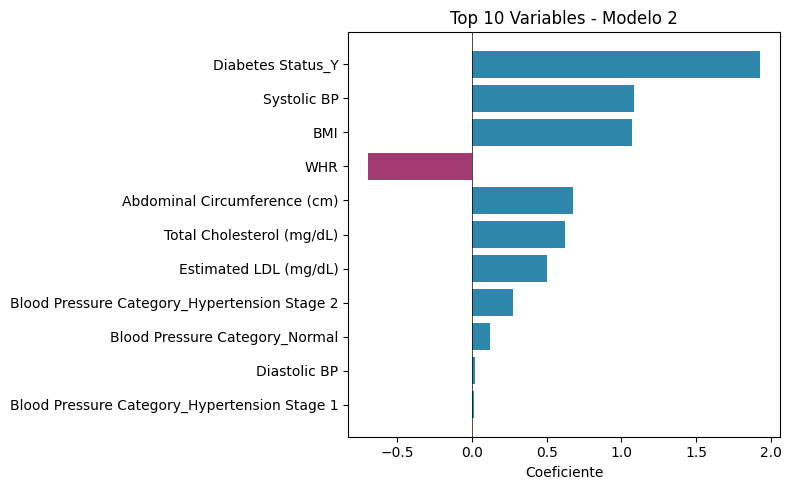

'\nSe utilizo la Inteligencia Aritificial de Chat GPT para generar el codigo que imprime los coeficientes de cada variable explicativa del modelo 2\ny ademas el codigo que genera la grafica de las 10 variables mas importantes del modelo 2, ordenadas por su valor absoluto, con colores diferenciados para coeficientes positivos y negativos.\n'

In [ ]:
# Obtener nombres de características transformadas
feature_names = numeric_features2.copy()

# Agregar variables categóricas transformadas
cat_encoder = model2.named_steps['preprocessor'].named_transformers_['cat']
cat_names = cat_encoder.get_feature_names_out(categorical_features2)
feature_names.extend(cat_names)

# Coeficientes
coefs = model2.named_steps['regressor'].coef_

# Ordenar por valor absoluto (para que WHR negativo aparezca arriba)
imp_df = pd.DataFrame({
    'Variable': feature_names,
    'Coeficiente': coefs
})
imp_df['Abs'] = np.abs(coefs)
imp_df = imp_df.sort_values('Abs', ascending=False)

print(imp_df[['Variable', 'Coeficiente']].to_string(index=False))
print(f"\nIntercepto: {model2.named_steps['regressor'].intercept_:.4f}")

# Gráfica simple
plt.figure(figsize=(8, 5))
plt.barh(range(len(imp_df)), imp_df['Coeficiente'][::-1], 
         color=['#2E86AB' if c > 0 else '#A23B72' for c in imp_df['Coeficiente'][::-1]])
plt.yticks(range(len(imp_df)), imp_df['Variable'][::-1])
plt.xlabel('Coeficiente')
plt.title('Top Variables - Modelo 2')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.show()

"""
Se utilizo la Inteligencia Aritificial de Chat GPT para generar el codigo que imprime los coeficientes de cada variable explicativa del modelo 2
y ademas el codigo que genera la grafica de las variables mas importantes del modelo 2, ordenadas por su valor absoluto, con colores diferenciados para coeficientes positivos y negativos.
"""

# Analisis de Resultados 

- **¿Cuál fue el valor de los diferentes coeficientes obtenidos en el mejor modelo?**

In [353]:
print(imp_df[['Variable', 'Coeficiente']].to_string(index=False))
print(f"\nIntercepto: {model2.named_steps['regressor'].intercept_:.4f}")

                                    Variable  Coeficiente
                           Diabetes Status_Y     1.930530
                                 Systolic BP     1.084219
                                         BMI     1.071687
                                         WHR    -0.696220
                Abdominal Circumference (cm)     0.678354
                   Total Cholesterol (mg/dL)     0.624490
                       Estimated LDL (mg/dL)     0.500045
Blood Pressure Category_Hypertension Stage 2     0.277699
              Blood Pressure Category_Normal     0.119543
                                Diastolic BP     0.017279

Intercepto: 15.9168


El análisis de regresión muestra que Diabetes Status es la variable con mayor impacto positivo en la variable dependiente (coeficiente +1.93), seguida por Systolic BP (+1.08) y BMI (+1.07).

WHR presenta un coeficiente negativo (-0.70), indicando una relación inversa con la variable objetivo. Esto resulta muy interesante pues contrasta con otras medidas como BMI y Abdominal Circumference que muestran relaciones positivas.

El intercepto de 15.92 representa el valor base cuando todas las variables son cero.


- **A partir de la tabla comparativa, ¿cuál modelo ofrece el mejor rendimiento sobre el conjunto test? ¿Qué interpretación puedes darles a los valores obtenidos sobre las métricas de rendimiento?** 

El Modelo 2 presenta un rendimiento ligeramente superior en todas las métricas evaluadas razón por la cual se deberia utilizar:

- R² (0.663 vs 0.657): Explica aproximadamente el 66.3% de la variabilidad de los datos, mejorando marginalmente al modelo completo. Esto indica una capacidad predictiva moderada.

- MAE (0.987 vs 0.999): En promedio, las predicciones del modelo se desvían en ±0.987 unidades del valor real, siendo ligeramente más preciso que el modelo completo.

- RMSE (1.491 vs 1.505): Al penalizar más los errores grandes, este valor confirma que el Modelo 2 comete errores ligeramente menores en magnitudes extremas.

Además tiene una cantidad significativa menor de variables explicativas lo que hace a el modelo mas sencillo y facil de entender.

- **¿Cuáles variables fueron seleccionadas con el modelo seleccionado? A partir de estas, ¿qué interpretación de cara al problema puedes dar? Reflexiona sobre cómo este nuevo conocimiento podría ayudar a tomar decisiones en el contexto del problema.**

El modelo final incluye 7 variables numéricas y 2 variables categóricas:

**Variables numéricas:**
- Abdominal Circumference (cm)
- Total Cholesterol (mg/dL)
- Systolic BP
- Diastolic BP
- Estimated LDL (mg/dL)
- BMI
- WHR

**Variables categóricas:**
- Diabetes Status
- Blood Pressure Category

Las variables con mayor impacto positivo son Diabetes Status (personas con diabetes presentan valores significativamente más altos), Systolic BP y BMI, lo que sugiere que el control de la presión arterial y el peso corporal son factores críticos.

El WHR con coeficiente negativo resulta interesante: a mayor relación cintura-cadera, menor es la variable objetivo, lo que podría indicar una relación no lineal o interacciones con otras variables como BMI o perímetro abdominal.

### Aplicación Práctica

Este modelo podria aplicarse para:
- Identificar pacientes en riesgo: priorizar intervenciones en personas con diabetes, presión arterial elevada y BMI alto
- Diseñar estrategias preventivas: enfocar recursos en control de presión arterial y manejo de peso
- Optimizar procesos: usar estas variables como indicadores tempranos sin necesidad de pruebas más invasivas

Ahora bien, naturalmente es una implementación que se debe manejar con precaución, pues esta puede seguir presentando fallas y errores de Tipo I y II, lo cual en su efecto puede afectar como se manejaria la situación del paciente en particular

El conocimiento generado ayuda a focalizar intervenciones médicas en los factores de mayor impacto, optimizando recursos y mejorando la efectividad de los programas de salud.

- **A partir del contexto y los datos compartidos, ¿cómo representar la regresión lineal de forma matemática? Indique el método utilizado y el proceso para resolverlo.**


**Forma General:**
$$Y = \beta_0 + \beta_1X_1 + \beta_2X_2 + ... + \beta_nX_n + \varepsilon$$

**Modelo estimado:**
$$
Y = 15.92
+ 1.93(Diabetes)
+ 1.08 (Systolic BP)
+ 1.07(IMC)
- 0.69(WHR)
$$
$$
+ 0.67(Abdominal-circumference)
+ 0.62(Colesterol)
+ 0.50(LDL)
$$
$$
+ 0.28(Stage 2)
+ 0.12(Normal)
+ 0.02(Diastolic BP)
+ 0.01(Stage 1)
$$

La estimacion de los Betas se hace mediante el Metodo de mínimos cuadrados (Gauss Markvo) el cual asegura que estos estimadores sean insesgados, eficientes y consistentes

$$\hat{\beta} = (X^TX)^{-1}X^TY$$


- **En el ciclo de machine learning ¿Qué tipos de sesgo podría afectar los resultados y por qué? Describe dos tipos de sesgo.**

1. Sesgo de Muestra

Ocurre cuando los datos de entrenamiento no representan a la población real. El modelo funciona bien en entrenamiento pero falla al generalizar, produciendo resultados injustos para grupos subrepresentados.

2. Sesgo Histórico o Preexistente

Los datos reflejan desigualdades sociales reales del pasado. El modelo aprende y perpetúa esos sesgos en sus predicciones, reproduciendo discriminación existente aunque no se usen atributos protegidos.

Ambos afectan la equidad del modelo y su capacidad para generalizar correctamente.

In [ ]:
# 1. Cargar datos de prueba
datos_test = pd.read_csv('./data/Datos Test Lab 1.csv', sep=';', skip_blank_lines=True)

# 2. Eliminar filas completamente vacías
datos_test = datos_test.dropna(how='all')

# 3. Eliminar columnas completamente vacías
datos_test = datos_test.dropna(axis=1, how='all')

# 4. **RELLENAR VALORES VACÍOS CON LA MEDIANA (igual que en entrenamiento)**
from sklearn.impute import SimpleImputer

num_cols_test = datos_test.select_dtypes(include=['int64','float64']).columns
imputer = SimpleImputer(strategy='median')
datos_test[num_cols_test] = imputer.fit_transform(datos_test[num_cols_test])

print(f"Valores NaN después de imputar: {datos_test.isna().sum().sum()}")

# 5. Mostrar qué quedó
print(f"Registros después de limpiar: {len(datos_test)}")
print(f"Columnas: {datos_test.shape[1]}")
print("\nPrimeras filas:")
print(datos_test.head())

# 6. Crear BMI
datos_test["BMI"] = datos_test["Weight (kg)"] / (datos_test["Height (m)"] ** 2)

# 7. Crear WHR
datos_test["WHR"] = datos_test["Abdominal Circumference (cm)"] / (datos_test["Height (m)"] * 100)

# 8. Hacer predicciones
predicciones = model2.predict(datos_test[X2.columns])

# 9. Guardar
datos_test['CVD Risk Score'] = predicciones
datos_test.to_csv('./data/Datos Test Lab 1.csv', index=False, sep=';')

print(f"Predicciones generadas: {len(predicciones)}")

"""
Se utilizo la Inteligencia Aritificial de Copilot para hacer las predicciones del modelo 2 en el data set de pruebas
y guardar los resultados. El codigo incluye pasos para cargar los datos, eliminar filas y columnas vacías, rellenar valores faltantes con la mediana 
y crear las variables BMI y WHR tal y como se hizo en el dataset de entrenamiento, para asegurar que el modelo pueda hacer las predicciones correctamente.



"""

Valores NaN después de imputar: 0
Registros después de limpiar: 194
Columnas: 22

Primeras filas:
  Patient ID Date of Service Sex   Age  Weight (kg)  Height (m)     BMI  \
0   WYTG8678       1/12/2021   M  44.0       51.936       1.936  36.442   
1   yloc1993      12-25-2020   F  30.0      115.000       1.830  34.300   
2   DDwq7653       23-sep-21   M  38.0       63.300       1.700  21.900   
3   YTcX6704       3/03/2021   F  58.0       72.300       1.740  23.900   
4   lZLi8935      06-14-2022   M  51.0       57.600       1.810  17.600   

   Abdominal Circumference (cm) Blood Pressure (mmHg)  \
0                       115.755               105/108   
1                        93.600                139/79   
2                        93.800                 93/67   
3                        91.600                 99/90   
4                       100.000                 97/84   

   Total Cholesterol (mg/dL)  ...  Smoking Status  Diabetes Status  \
0                      107.0  ...     